In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image



#import requests
import os
import sys
import time
import shutil
import random
from tqdm import tqdm

from pathlib import Path


from sklearn.metrics import (auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve, 
    roc_auc_score,
    log_loss,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    )
from sklearn.preprocessing import label_binarize


# --- Pytorch--
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device used is {device}")

Device used is cpu


In [3]:
def set_seed(seed: int = 42)-> None:
    """Seed Python, NumPy, and PyTorch (CPU & all GPUs) and
    make cuDNN run in deterministic mode."""
    # ---- Python and NumPy ------------------------------------------
    random.seed(seed)
    np.random.seed(seed)
    
    # ---- PyTorch (CPU  &  GPU) -------------------------------------
    torch.manual_seed(seed)            
    torch.cuda.manual_seed_all(seed)   
    
    # ---- cuDNN: force repeatable convolutions ----------------------
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False

In [4]:
SEED = 42
set_seed(SEED)
print(f"Global seed set to {SEED} — main process is now deterministic.")

Global seed set to 42 — main process is now deterministic.


## Loading Data

In [5]:
#======================================================================================================
#LOCAL_FILE_PATH = "C:/Users/normaqp/Downloads/flower_photos.tar.gz" 
#======================================================================================================

EXTRACTION_DIR = "C:/Users/normaqp/Downloads/extracted_data/"
flowers_path = os.path.join(EXTRACTION_DIR, 'flower_photos')
os.makedirs(flowers_path, exist_ok=True)

print("✅ Flowers dataset folder ready at:", flowers_path)
print("Subfolders:", os.listdir(flowers_path))

✅ Flowers dataset folder ready at: C:/Users/normaqp/Downloads/extracted_data/flower_photos
Subfolders: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [6]:
#======================================================================================================
# Select two classes of flowers: Daisy and Sunflowers. 
#======================================================================================================

# directories of the two selected classes
daisy_path = os.path.join(flowers_path, "daisy")
sunflowers_path = os.path.join(flowers_path, "sunflowers")

print("Daisy directory:",daisy_path)
print("Sunflowers directory:", sunflowers_path)

# destination directory with only 2 classes
subset_path = os.path.join(EXTRACTION_DIR, "daisy_sun")
os.makedirs(subset_path, exist_ok=True)

# copy both folders into the new binary directory
for class_path in [daisy_path, sunflowers_path]:
    class_name = os.path.basename(class_path)       # e.g., "daisy"
    folder = os.path.join(subset_path, class_name)   # e.g., daisy_sun/daisy
    shutil.copytree(class_path, folder, dirs_exist_ok=True)  # to recreate the new  dataset each session
    
print("Binary balanced dataset created at:", subset_path)


Daisy directory: C:/Users/normaqp/Downloads/extracted_data/flower_photos\daisy
Sunflowers directory: C:/Users/normaqp/Downloads/extracted_data/flower_photos\sunflowers
Binary balanced dataset created at: C:/Users/normaqp/Downloads/extracted_data/daisy_sun


In [7]:
#======================================================================================================
# Look formats of the pictures
#======================================================================================================

class_labels = ["daisy", "sunflowers"]

for class_name in class_labels:
    folder = os.path.join(subset_path, class_name)
    
    # Collect all extensions found in this folder
    exts = set()

    for filename in os.listdir(folder):
        _, ext = os.path.splitext(filename)
        exts.add(ext.lower())
    
    print(f"Extensions found in {class_name}:", exts)

Extensions found in daisy: {'.jpg'}
Extensions found in sunflowers: {'.jpg'}


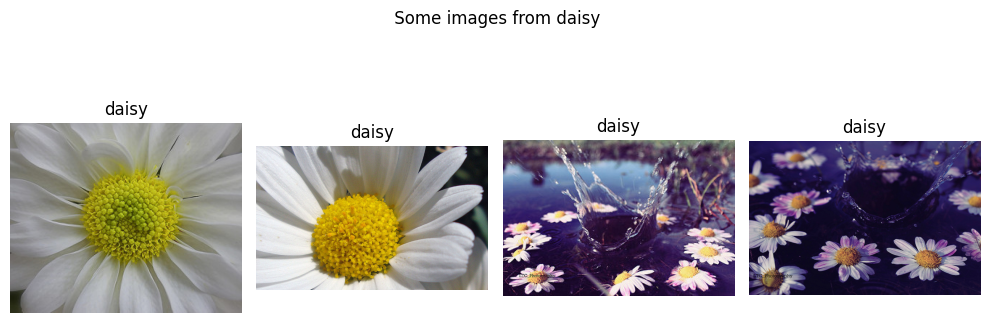

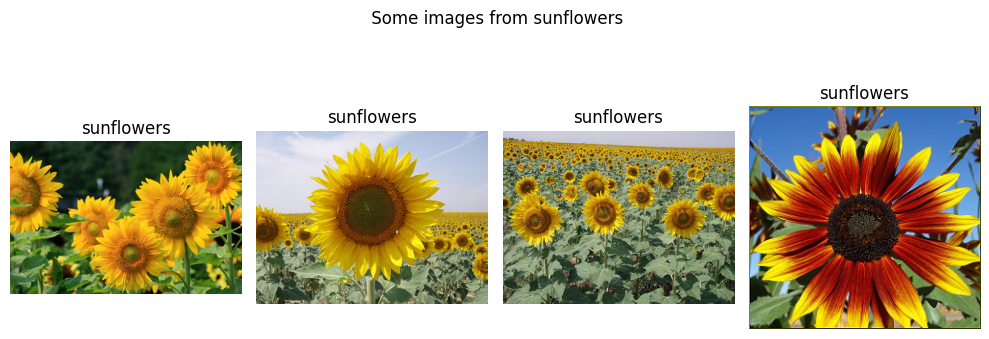

In [8]:
#======================================================================================================
# Select some pictures
#======================================================================================================
for class_name in ["daisy", "sunflowers"]:
    folder = os.path.join(subset_path, class_name)

    # List only image files
    files = [f for f in os.listdir(folder)]

    # Select first 3 images (or change number)
    files = files[: 4]

    # Plot
    plt.figure(figsize=(10, 4))

    for i, filename in enumerate(files):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path)

        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{class_name}")

    plt.suptitle(f" Some images from {class_name}")
    plt.tight_layout()
    plt.show()


## Preprocessing Data 

### Hyperparameters 

In [9]:
#======================================================================================================
# Define the hyperparameters
#======================================================================================================

img_size = 128
batch_size = 16
epochs = 25 
model_name = "Daisy_Sunflowers_capstone_pytorch_state_dict.pth"
num_classes = 2  #number of classes in the dataset 5


### Transformation

In [10]:
train_transform = transforms.Compose([transforms.Resize((img_size, img_size)),
                                       transforms.RandomRotation(20),
                                        transforms.RandomHorizontalFlip(p = 0.5),
                                        transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                        transforms.ToTensor(),  # Converts PIL Image to a tensor and scales values to [0, 1]
                                        transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
                                        ])

In [11]:
# validation doesn´t transform
val_transform = transforms.Compose([
                 transforms.Resize((img_size, img_size)),
                 transforms.ToTensor(),
                 transforms.Normalize(mean = [0.5, 0.5, 0.5], std = [0.5, 0.5, 0.5])
 ])

In [12]:
#======================================================================================================
# # Load the dataset for training
#======================================================================================================

daisysun_dataset = datasets.ImageFolder(root = subset_path, transform = train_transform)

## Split data into Train,  Validation and Test

In [13]:
#======================================================================================================
# Split data
#======================================================================================================

total_size = len(daisysun_dataset)
train_size = int(0.6 * total_size)  # 80%
val_size = int(0.2 * total_size)    # 20 %
test_size = total_size - train_size - val_size # 20%


train_dataset, val_dataset, test_dataset = random_split(daisysun_dataset, [train_size, val_size, test_size])
val_dataset.dataset.transform = val_transform

In [14]:
#======================================================================================================
# DataLoaders
#======================================================================================================
train_loader = torch.utils.data.DataLoader(train_dataset, 
                          batch_size = batch_size,
                          shuffle=True,
                          num_workers=0,  # set 0 for CPU
                         )


# Validation Data Loader
val_loader   = torch.utils.data.DataLoader(val_dataset,   
                                           batch_size=batch_size, 
                                           shuffle=False,  
                                           num_workers=0)


In [15]:
#======================================================================================================
# Define the model
#======================================================================================================

class FlowersCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2), nn.BatchNorm2d(256),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x



In [16]:
#======================================================================================================
# Train the model
#======================================================================================================

def train_model(model, optimizer, criterion, train_loader, val_loader, device, epochs):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val = float('inf')

    model.to(device)

    for epoch in range(epochs):
       
        # ---- Training ----
        model.train()
        running_loss = 0.0 
        correct = 0 
        total = 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc  = correct / total

        # ---- Validation ----
        model.eval()
        val_loss_run = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)

                val_loss_run += criterion(logits, y).item()
                preds = logits.argmax(1)
                val_correct += (preds == y).sum().item()
                val_total += y.size(0)

        val_loss = val_loss_run / len(val_loader)
        val_acc  = val_correct / val_total

        # Save history
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if val_loss < best_val:
            best_val = val_loss

        print(f"Epoch {epoch+1}/{epochs} | "
              f"T_Loss: {train_loss:.4f} Val_Loss: {val_loss:.4f} | "
              f"T_Acc: {train_acc:.3f} Val_Acc: {val_acc:.3f}")

    return history




In [17]:
#======================================================================================================
# CrossEntropy and  Adam optimazer
#======================================================================================================

model_adam = FlowersCNN(num_classes).to(device)
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=1e-4,  weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

adam_history = train_model(
    model_adam, optimizer_adam, criterion,
    train_loader, val_loader,
    device, epochs=25
)






Epoch 1/25 | T_Loss: 0.4264 Val_Loss: 0.3200 | T_Acc: 0.817 Val_Acc: 0.857
Epoch 2/25 | T_Loss: 0.2844 Val_Loss: 0.2604 | T_Acc: 0.882 Val_Acc: 0.891
Epoch 3/25 | T_Loss: 0.2364 Val_Loss: 0.2691 | T_Acc: 0.910 Val_Acc: 0.887
Epoch 4/25 | T_Loss: 0.2257 Val_Loss: 0.2031 | T_Acc: 0.909 Val_Acc: 0.914
Epoch 5/25 | T_Loss: 0.1939 Val_Loss: 0.2268 | T_Acc: 0.919 Val_Acc: 0.906
Epoch 6/25 | T_Loss: 0.1831 Val_Loss: 0.2316 | T_Acc: 0.927 Val_Acc: 0.914
Epoch 7/25 | T_Loss: 0.1468 Val_Loss: 0.2155 | T_Acc: 0.945 Val_Acc: 0.921
Epoch 8/25 | T_Loss: 0.1749 Val_Loss: 0.2351 | T_Acc: 0.924 Val_Acc: 0.914
Epoch 9/25 | T_Loss: 0.1880 Val_Loss: 0.2236 | T_Acc: 0.931 Val_Acc: 0.910
Epoch 10/25 | T_Loss: 0.1792 Val_Loss: 0.2071 | T_Acc: 0.930 Val_Acc: 0.921
Epoch 11/25 | T_Loss: 0.1443 Val_Loss: 0.2118 | T_Acc: 0.941 Val_Acc: 0.921
Epoch 12/25 | T_Loss: 0.2026 Val_Loss: 0.2549 | T_Acc: 0.924 Val_Acc: 0.914
Epoch 13/25 | T_Loss: 0.1377 Val_Loss: 0.1880 | T_Acc: 0.960 Val_Acc: 0.944
Epoch 14/25 | T_Loss:

In [18]:
#======================================================================================================
# CrossEntropy and  SGD optimazer
#======================================================================================================

model_sgd = FlowersCNN(num_classes).to(device)

optimizer_sgd = torch.optim.SGD(
    model_sgd.parameters(),
    lr=0.01,
    momentum=0.9,
    weight_decay=1e-4
)

criterion = nn.CrossEntropyLoss()

sgd_history = train_model(
    model_sgd, optimizer_sgd, criterion,
    train_loader, val_loader,
    device, epochs=25
)


Epoch 1/25 | T_Loss: 0.4413 Val_Loss: 0.3621 | T_Acc: 0.814 Val_Acc: 0.823
Epoch 2/25 | T_Loss: 0.3644 Val_Loss: 0.7176 | T_Acc: 0.865 Val_Acc: 0.744
Epoch 3/25 | T_Loss: 0.3042 Val_Loss: 0.3162 | T_Acc: 0.874 Val_Acc: 0.865
Epoch 4/25 | T_Loss: 0.2911 Val_Loss: 0.3092 | T_Acc: 0.886 Val_Acc: 0.876
Epoch 5/25 | T_Loss: 0.2609 Val_Loss: 0.2202 | T_Acc: 0.909 Val_Acc: 0.895
Epoch 6/25 | T_Loss: 0.2627 Val_Loss: 0.3007 | T_Acc: 0.906 Val_Acc: 0.887
Epoch 7/25 | T_Loss: 0.2848 Val_Loss: 0.1900 | T_Acc: 0.891 Val_Acc: 0.906
Epoch 8/25 | T_Loss: 0.2475 Val_Loss: 0.2576 | T_Acc: 0.904 Val_Acc: 0.906
Epoch 9/25 | T_Loss: 0.2558 Val_Loss: 0.2502 | T_Acc: 0.885 Val_Acc: 0.906
Epoch 10/25 | T_Loss: 0.2420 Val_Loss: 0.2567 | T_Acc: 0.900 Val_Acc: 0.910
Epoch 11/25 | T_Loss: 0.2421 Val_Loss: 0.2488 | T_Acc: 0.905 Val_Acc: 0.914
Epoch 12/25 | T_Loss: 0.1948 Val_Loss: 0.2532 | T_Acc: 0.925 Val_Acc: 0.917
Epoch 13/25 | T_Loss: 0.2151 Val_Loss: 0.2055 | T_Acc: 0.924 Val_Acc: 0.898
Epoch 14/25 | T_Loss:

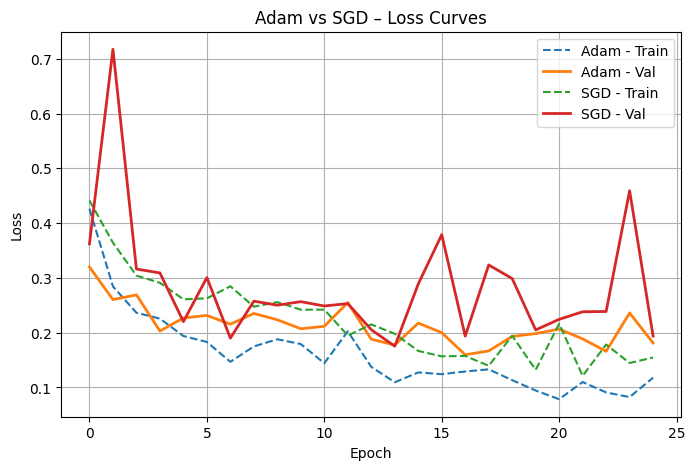

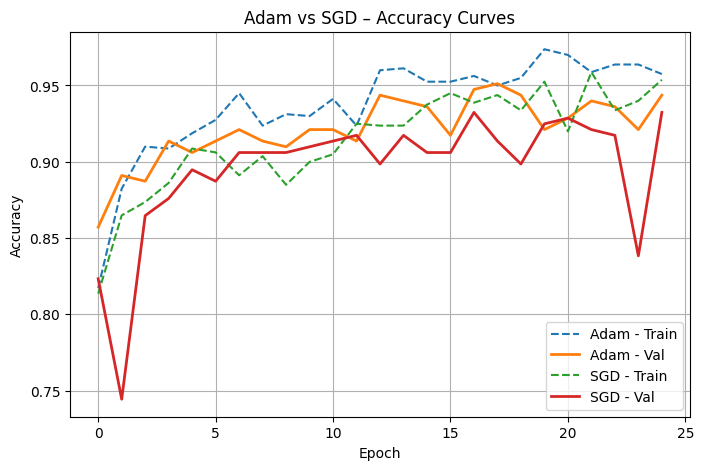

In [19]:
# ---------------------------------------------------------
#  Function to plot curves
# ---------------------------------------------------------
def plot_metric(adam_history, sgd_history, metric, ylabel, title):
    plt.figure(figsize=(8,5))

    # Adam curves
    plt.plot(adam_history[f"train_{metric}"], label="Adam - Train", linestyle="--")
    plt.plot(adam_history[f"val_{metric}"], label="Adam - Val", linewidth=2)

    # SGD curves
    plt.plot(sgd_history[f"train_{metric}"], label="SGD - Train", linestyle="--")
    plt.plot(sgd_history[f"val_{metric}"], label="SGD - Val", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------
# Plot Loss comparison (Train + Validation)
# ---------------------------------------------------------
plot_metric(
    adam_history, sgd_history,
    metric="loss",
    ylabel="Loss",
    title="Adam vs SGD – Loss Curves"
)

# ---------------------------------------------------------
# Plot Accuracy comparison (Train + Validation)
# ---------------------------------------------------------
plot_metric(
    adam_history, sgd_history,
    metric="acc",
    ylabel="Accuracy",
    title="Adam vs SGD – Accuracy Curves"
)



The loss plots show that:

* Adam has a lower validation loss curve. Althoug the differences are very tiny.

* Adam has smoother curves. The loss curve for SGD are more spikes.

* The train loss curves and validation loss curves decrease almost to the same ratio, indicating that the model is doing well learning patterns. The gap between them is not large, so there is no severe overfitting.

The accuracy plots:
* The validation accuracy for Adam optimization is a little higher than for the SGD 

* Both accuracies increase and reach a plateau around 12 epochs, indicating that the model has achieved its best performance.

* No overfitting.

Based on these results, I decided to continue with Adam optimization. 


In [20]:
# ---------------------------------------------------------
# Predictions for Adam optimization
# ---------------------------------------------------------
predictions = []
targets = []  # true labels

model_adam.eval()
with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch = x_batch.to(device)

        logits = model_adam(x_batch)
        batch_preds = logits.argmax(1)

        predictions.extend(batch_preds.cpu().tolist())
        targets.extend(y_batch.tolist())


In [21]:
accuracy = accuracy_score(targets, predictions)
print(f"The accuracy of the model is: {accuracy:.4f}")

The accuracy of the model is: 0.9436


In [22]:
# ---------------------------------------------------------
# Test
# ---------------------------------------------------------


import torch.nn.functional as F

# Data loader for test partition
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Ensure model and data share the same device
model_adam.to(device)
model_adam.eval()

num_correct = 0
num_samples = 0

pred_list   = []  # predicted 
label_list  = []  #true labels
prob_list   = []   # for class-1 probabilities

with torch.no_grad():     # evaluation uses no gradients
    for xt, yt in test_loader:
        
        xt, yt = xt.to(device), yt.to(device)

        # Forward pass
        logits = model_adam(xt)

        # Get probability of positive class (class index 1)
        class1_prob = F.softmax(logits, dim=1)[:, 1]

        # Predicted class index
        preds = logits.argmax(1)

        # Update accuracy counters
        num_samples += yt.size(0)
        num_correct += (preds == yt).sum().item()

        #  store predictions and labels
        pred_list.extend(preds.cpu().tolist())
        label_list.extend(yt.cpu().tolist())
        prob_list.extend(class1_prob.cpu().tolist())


# Final test accuracy
test_acc = 100 * num_correct / num_samples
print(f"Test Accuracy: {test_acc:.2f}%")


Test Accuracy: 97.75%


In [23]:
y_true = label_list
y_pred = pred_list
y_prob = prob_list

# ---------------------------------------------------------
# Evaluations metrics
# ---------------------------------------------------------
# Accuracy
accuracy = accuracy_score(y_true =y_true, y_pred = pred_list) 

# ROC-AUC (for predicted probabilities)
roc_auc = roc_auc_score(y_true = y_true,  y_score = prob_list)

# Binary Cross-Entropy Loss (for predicted probabilities)
loss = log_loss(y_true = label_list, y_pred = pred_list)

print(f"Evaluation metrics for the model:")

print(f"Accuracy: {accuracy*100:.2f}%")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Log Loss: {loss:.4f}")
print()
print(f"Classification report:")
print(classification_report(y_true = label_list,  y_pred = pred_list , target_names = ["daisy", "sunflowers"]))





Evaluation metrics for the model:
Accuracy: 97.75%
ROC-AUC: 0.998
Log Loss: 0.8100

Classification report:
              precision    recall  f1-score   support

       daisy       0.98      0.97      0.98       134
  sunflowers       0.97      0.98      0.98       133

    accuracy                           0.98       267
   macro avg       0.98      0.98      0.98       267
weighted avg       0.98      0.98      0.98       267



========= Confusion Matrix =========
[[130   4]
 [  2 131]]


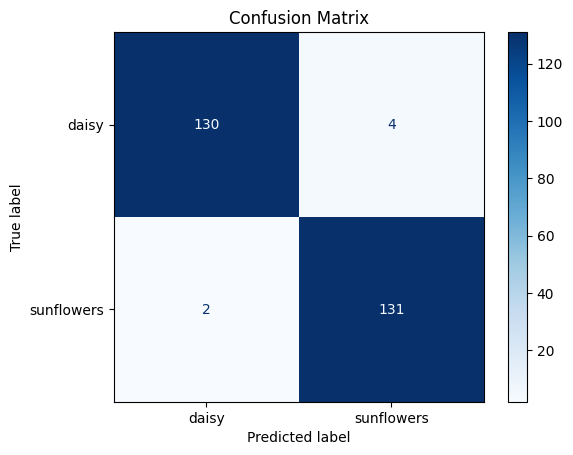

In [24]:
print("========= Confusion Matrix =========")
cm = confusion_matrix(y_true = label_list,  y_pred = pred_list)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= class_labels)


#print("Confusion matrix")
print(disp.confusion_matrix)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


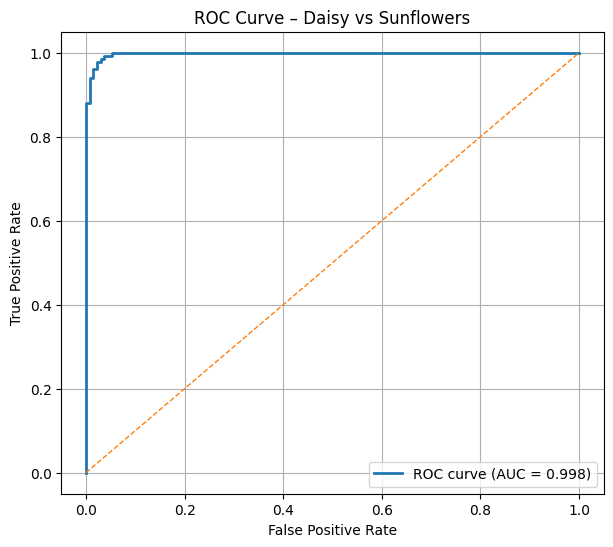

In [25]:
# ---------------------------------------------------------
# ROC curve
# ---------------------------------------------------------


fpr, tpr, thresholds = roc_curve(label_list, prob_list)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, linewidth=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', linewidth=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Daisy vs Sunflowers")
plt.legend()
plt.grid(True)
plt.show()



Found 6 misclassified samples.



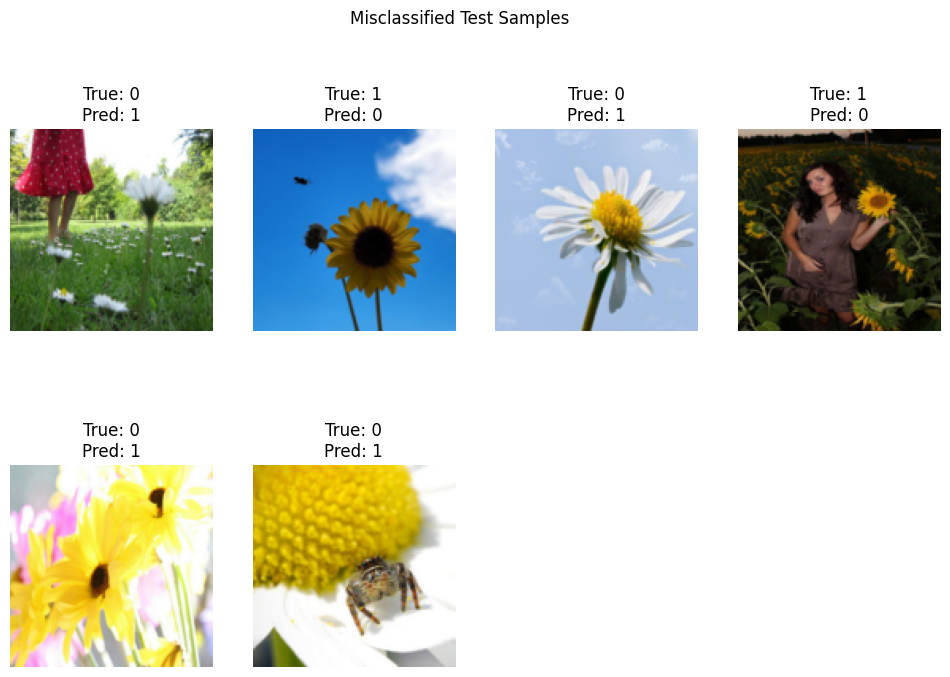

In [26]:
# ---------------------------------------------------------
# See misclassifications
# ---------------------------------------------------------

model_adam.eval()

misclassified_images = []
misclassified_true = []
misclassified_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model_adam(images)
        _, preds = torch.max(outputs, 1)

        # find indices where prediction is wrong
        wrong = preds != labels

        if wrong.any():
            misclassified_images.extend(images[wrong].cpu())
            misclassified_true.extend(labels[wrong].cpu().numpy())
            misclassified_pred.extend(preds[wrong].cpu().numpy())

# If no misclassifications
if len(misclassified_images) == 0:
    print("🎉 No misclassified samples found in the test set!")
else:
    print(f"Found {len(misclassified_images)} misclassified samples.\n")

    # Plot first 8 misclassified samples
    num_to_show = min(8, len(misclassified_images))

    plt.figure(figsize=(12, 8))
    for i in range(num_to_show):
        img = misclassified_images[i]
        true_label = misclassified_true[i]
        pred_label = misclassified_pred[i]

        img = img.permute(1, 2, 0)  # CHW → HWC
        img = img * torch.tensor([0.5, 0.5, 0.5]) + torch.tensor([0.5, 0.5, 0.5])  # unnormalize
        img = img.clamp(0, 1)

        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_label}\nPred: {pred_label}")

    plt.suptitle("Misclassified Test Samples")
    plt.show()


Acknowledgments

Special thanks to the IBM course  "AI Capstone Project with Deep Learning course", which helped me understand several supporting ideas used in this project. While the model  and analyses were developed independently as part of my own learning process, the utility functions   "set_seed()" and the "misclassified-image display" were  copied from some of the ungraded labs provided in the *IBM AI Capstone Project with Deep Learning* were these utilities were part of the learning material. Addinianlly,  the *generator-based data loading code* was adapted to fit my dataset. 



